In [1]:
using AA222
using PyPlot
using Distributions
using Sobol

# Random Latin Hypercube

In [2]:
function rlh(n, k)
    X = zeros(k, n)
    for i = 1:k
        X[i,:] = randperm(n)
    end
    X = (X - 0.5)/n
end

rlh (generic function with 1 method)

[0.9 0.7 0.3 0.5 0.1
 0.1 0.7 0.3 0.5 0.9]

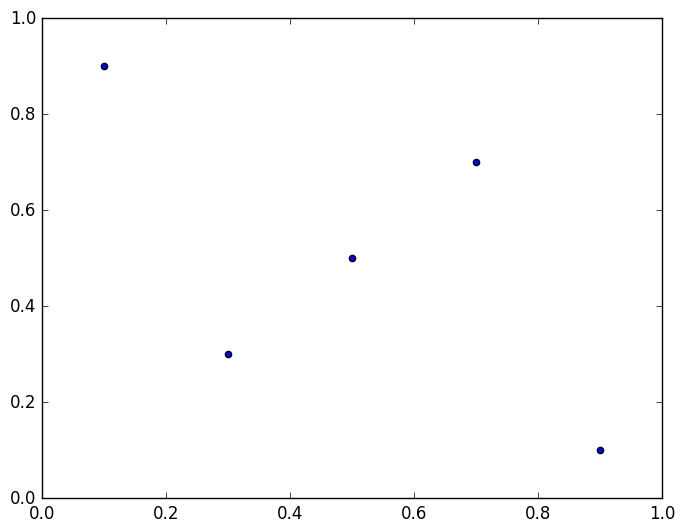

In [3]:
X = rlh(5,2)
scatter(X)
show(X)

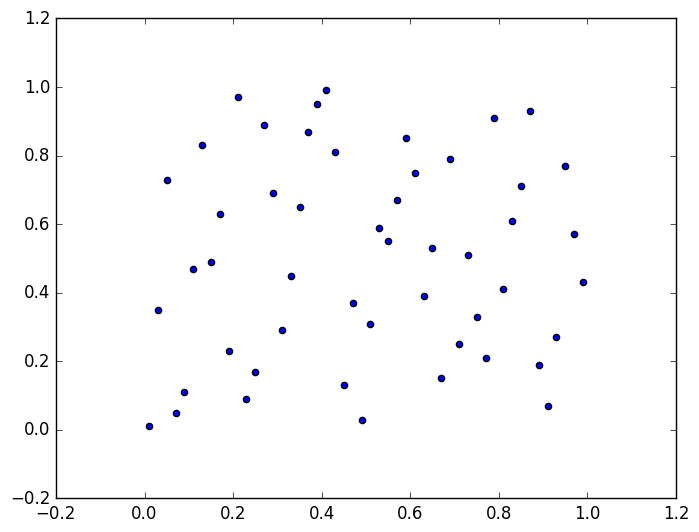

In [4]:
scatter(rlh(50,2));

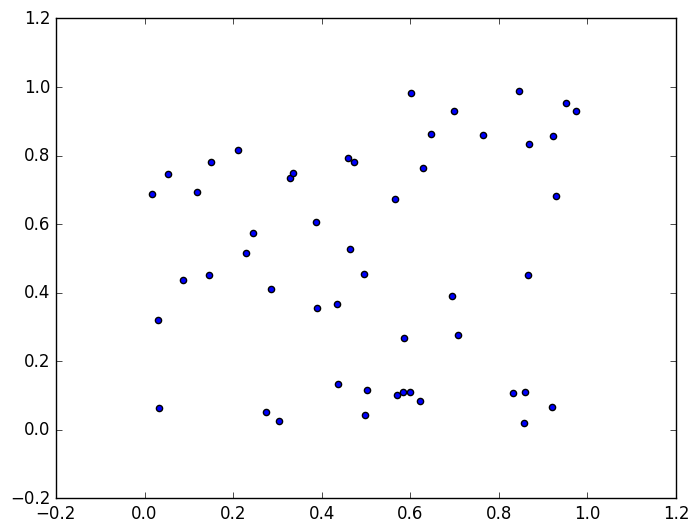

In [5]:
scatter(rand(50),rand(50));

# Space Filling Latin Hypercubes

In [6]:
function sortCount(v)
    distinctElements = sort(unique(v))
    counts = [sum(x .== v) for x = distinctElements]
    distinctElements, counts
end

sortCount (generic function with 1 method)

In [7]:
sortCount([1,2,3,2,1,3,3]) # just checking that this works

([1,2,3],[2,2,3])

In [8]:
# return all pairs of distances using p-norm
function pdist(X, p)
    n = size(X,2)
    d = zeros(round(UInt, n*(n-1)/2))
    ind = 1
    for i = 1:(n-1)
        for j = (i+1):n
            d[ind] = norm(X[:,i] - X[:,j], p)
            ind += 1
        end
    end
    d
end

pdist (generic function with 1 method)

In [9]:
# Compares plans X1 and X2 according to maximin criteria
# using p-norm. Returns -1 if X1 is more space filling, 1 if X2 is more space filling
# and 0 if they are equal
function plancmp(X1, X2, p)
    (d1, J1) = sortCount(pdist(X1, p))
    (d2, J2) = sortCount(pdist(X2, p))
    n = min(length(d1), length(d2)) # only need to pay attention to shorter one
    for i = 1:n
        if d1[i] < d2[i]
            return 1
        elseif d1[i] > d2[i]
            return -1
        elseif J1[i] < J2[i]
            return -1
        elseif J1[i] > J2[i]
            return 1
        end
    end
    return 0
end

plancmp (generic function with 1 method)

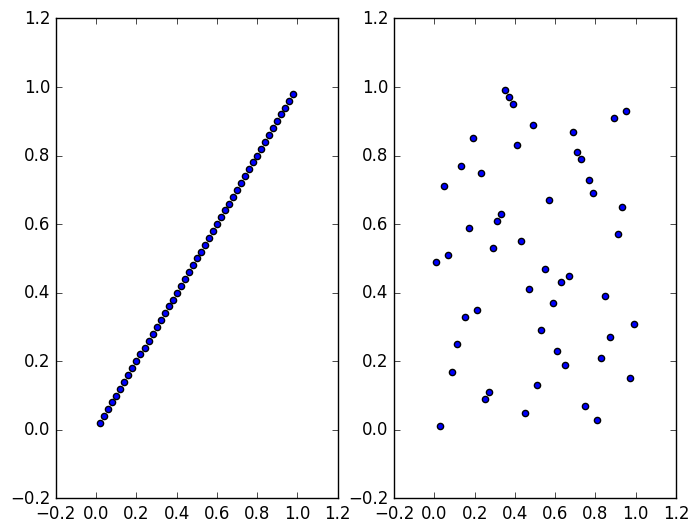

1

In [10]:
X1 = [(1:50 - 0.5)/50 (1:50 - 0.5)/50]'
X2 = rlh(50,2)
subplot(1,2,1)
scatter(X1)
subplot(1,2,2)
scatter(X2)
plancmp(X1,X2,2)

Morris and Mitchell found searching using plancmp does not work well due to landscape. Instead, they suggest using the following function assuming some constant $q$  
$$\Phi_q(X) = \left( \sum_{j=1}^m J_j d_j^{-q} \right)^{1/q}$$

In [11]:
function phiq(X, q, p)
    (d, J) = sortCount(pdist(X, p))
    dot(J,d.^-q)^(1/q)
end

phiq (generic function with 1 method)

Morris and Mitchell recommend minimizing $\Phi_q$ for $q = 1, 2, 3, 10, 20, 50, 100$ and then use minimax to choose the best of those.

In [12]:
X = [rlh(10,2) for i=1:24]
push!(X, [(1:10 - 0.5)/10 (1:10 - 0.5)/10]');

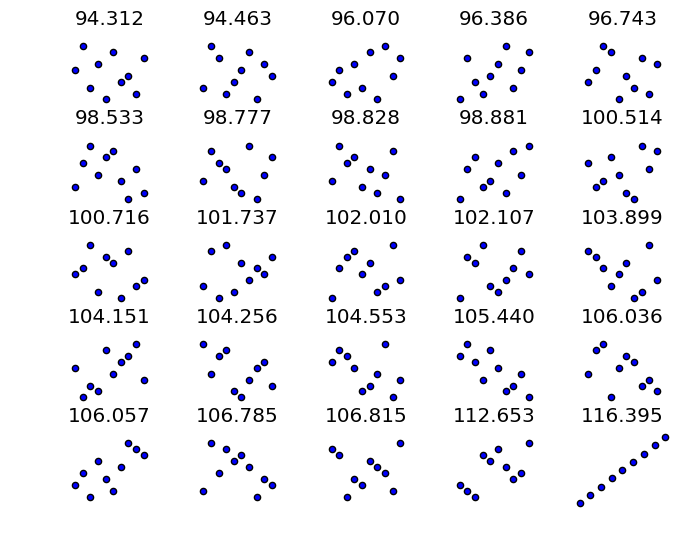

In [13]:
X = sort(X, by=x->phiq(x,1,2))
ind = 1
for i = 1:5
    for j = 1:5
        subplot(5,5,ind)
        axis("off")
        scatter(X[ind])
        title(@sprintf("%.3f", phiq(X[ind],1,2)))
        ind += 1
    end
end

In [14]:
# mutate X, maintaining Latin hypercube status
# this can be used for simulated annealing or some other search method
function mutate(X)
    (n, k) = size(X) # n samples, k dimensions
    j = sample(1:k)
    i = sample(1:n, 2, replace = false)
    # swap X[i[1],j] and X[i[2],j]
    tmp = X[i[1],j]
    X[i[1],j] = X[i[2],j]
    X[i[2],j] = tmp
end    

mutate (generic function with 1 method)

# Sobol Sequence

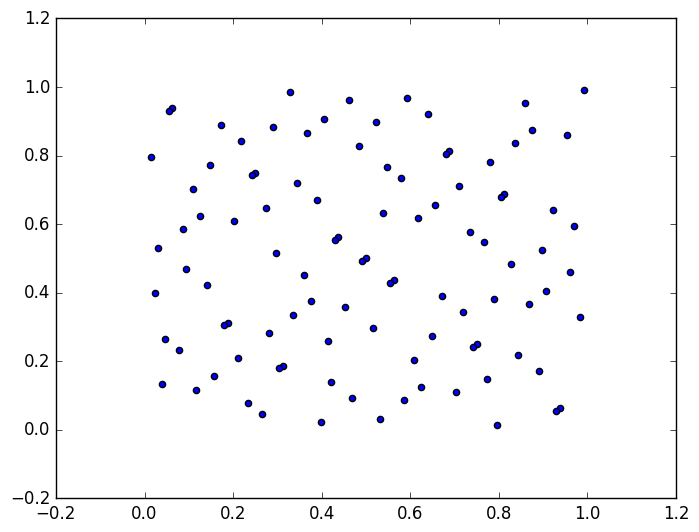

In [15]:
function SobolPlan(n) 
    s = SobolSeq(2) # two dimensional Sobol sequence
    hcat([next(s) for i = 1:n]...)
end
X = SobolPlan(100)
scatter(X);

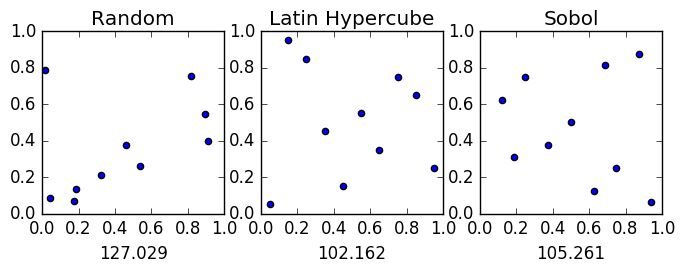

In [16]:
# plot function
function plotPlan(name, X, i)
    subplot(1,3,i,aspect="equal")
    title(name)
    scatter(X)
    xlim(0,1)
    ylim(0,1)
    xlabel(@sprintf("%.3f", phiq(X,1,2)))
end
n = 10
plotPlan("Random", [rand(n) rand(n)]', 1)
plotPlan("Latin Hypercube", rlh(n,2), 2)
plotPlan("Sobol", SobolPlan(n), 3);

In [17]:
@time rlh(10000,2);
@time SobolPlan(10000);

  0.000997 seconds (160 allocations: 635.558 KB)
  0.009453 seconds (19.52 k allocations: 1.214 MB, 53.23% gc time)
